## Final Project Submission

Please fill out:
* Student name: Samuel Marder
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Matt Carr
* Blog post URL: https://medium.com/@samuel.s.marder/slight-right-onto-data-science-64912ef3bd67


## Set up standard imports for data

In [1]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect("data/im.db")

In [3]:
q = """SELECT p.primary_name,
mb.primary_title
FROM persons as p 
JOIN directors USING (person_id)
JOIN movie_basics as mb USING (movie_id)"""
director_movie_df = pd.read_sql(q, conn).drop_duplicates()
director_movie_df.head()

,primary_name,primary_title
0,Ruel S. Bayani,Paano na kaya
4,Ruel S. Bayani,No Other Woman
7,Ruel S. Bayani,One More Try
8,Ruel S. Bayani,Kasal
10,Bryan Beasley,The Quiet Philanthropist: The Edith Gaylord Story


In [4]:
q = """SELECT mb.primary_title,
mb.original_title,
mb.start_year,
mb.runtime_minutes,
mb.genres
FROM movie_basics as mb"""
movie_df = pd.read_sql(q, conn).drop_duplicates()
movie_df['genres'] = movie_df['genres'].str.split(pat=",")
movie_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres
0,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]"
1,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]"
2,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama]
3,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[Comedy, Drama]"
4,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]"


In [5]:
genre_df = movie_df.explode('genres')
genre_df['genres'].value_counts().head()

Documentary    51590
Drama          49859
Comedy         25303
Thriller       11879
Horror         10798
Name: genres, dtype: int64

## Create a dataframe for movie budgets

I chose to read in the movie budgets csv file to find that the information in it was very string based. With some help from Yoni, I was able to clean the strings away in favor of numbers so I could calculate the ROI.

In [12]:
mb_df = pd.read_csv("data/tn.movie_budgets.csv")
mb_df = mb_df.set_index('movie')

mb_df['production_budget'].replace(to_replace=r'\D', value=r'', regex=True, inplace=True)
mb_df['production_budget'] = mb_df['production_budget'].astype(int)

mb_df['domestic_gross'].replace(to_replace=r'\D', value=r'', regex=True, inplace=True)
mb_df['domestic_gross'] = mb_df['domestic_gross'].astype(int)

mb_df['worldwide_gross'].replace(to_replace=r'\D', value=r'', regex=True, inplace=True)
mb_df['worldwide_gross'] = mb_df['worldwide_gross'].astype(float) #Turns out, int is too small here

mb_df['roi'] = mb_df['domestic_gross'] + mb_df['worldwide_gross'] - mb_df['production_budget'] 

mb_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi
movie,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2.776345e+09,3.111853e+09
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1.045664e+09,8.761278e+08
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,1.497624e+08,-1.574753e+08
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1.403014e+09,1.531420e+09
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1.316722e+09,1.619903e+09


## Create and visualize Director ROI Dataframe

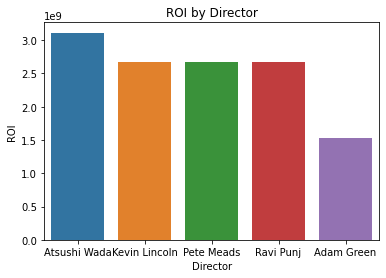

In [13]:
director_roi_df = mb_df.join(director_movie_df.set_index('primary_title'), how="inner")\
    .groupby(['primary_name']).mean()
director_roi_df.sort_values(['roi'], ascending=False, inplace=True)
director_roi_df.reset_index(inplace=True)

f, ax = plt.subplots()
sns.barplot(x="primary_name", y="roi", data=director_roi_df.head())
ax.set(xlabel="Director", ylabel="ROI", title="ROI by Director");

## Create and visualize the Genre ROI Dataframe

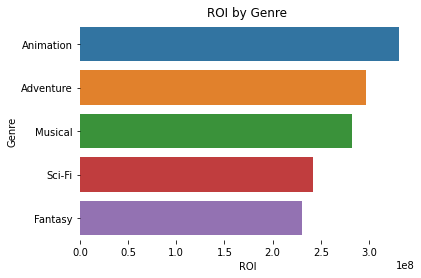

In [8]:
genre_roi_df = mb_df.join(genre_df.set_index('primary_title'), how="inner")\
    .groupby(['genres']).mean()
genre_roi_df.sort_values(['roi'], ascending=False, inplace=True)
genre_roi_df.reset_index(inplace=True)

f, ax = plt.subplots()
sns.barplot(x="roi", y="genres", data=genre_roi_df.head())
ax.set(ylabel="Genre", xlabel="ROI", title="ROI by Genre")
sns.despine(left=True, bottom=True)

## Create and visualize Runtime ROI Dataframe

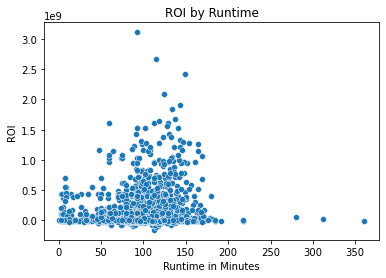

In [9]:
rt_roi_df = mb_df.join(movie_df.set_index("primary_title"), how="inner")
rt_roi_df.dropna(subset=["runtime_minutes"], inplace=True)

f, ax = plt.subplots()
sns.scatterplot(x="runtime_minutes", y="roi", data=rt_roi_df);
ax.set(xlabel="Runtime in Minutes", ylabel="ROI", title="ROI by Runtime");

## Recommendations:
1. Do an animated film
2. Hire Atsushi Wada to direct
3. The best seems to be around 100 minutes in runtime so I would go for that